<img src="https://drive.google.com/uc?id=1B_R8TgTfQ1LhG5DWlNIomuyt2_CkjorZ" alt="Chicago Taxi Ride Analysis" width="500"/>


**TEAM 7**

**Team members**: Prateek Naharia,Linting Wang, Sifan Zhu, Jiadai Yu, Tyler Christoforo

## 🚕 Chicago Taxi Ride Analysis

I. **Introduction**

   a. Motivation

   b. Objective

   c. Data description

II. [**Data Reading**](#datareading)

    a. Input Data

    b. Data Schema

    c. Gaining Data Understanding

III. [**Data Cleaning**](#datacleaning)

     a. Column Selection

     b. Spurious, Splits and Merges

     c. Imputing Nulls

IV. [**Data Analysis & Visualizations**](#QA)

    1. At what price point are customers most likely to take a taxi?

    2. What is the relation between fares and miles?

    3. What are the popular pickup and dropoff locations?

    4. Which Taxi Companies have the highest average tips?

    5. What is the correlation between Company, Miles, and Tips?

    6. What are the common payment types?

    
V. [**Conclusions**](#conclusions)

VI. [**Reference**](#references)


## Introduction


**Problem definition**:

   After Uber and other taxi platforms took over the taxi market, it has left traditional taxi services quite vulnerable. Although these companies have looked into online platforms, they have long lost their original market shares. Therefore, this projects aims to focus on tradition taxi services' data and analyze trends and patterns to determine potential opportunities in aiding traditional taxi service companies.
    
**a.Motivation**

   In order to better provide aid to taxi service companies, the taxi trip dataset will help us gain insights on trends in the taxi industry. Moreover, these insights can be developed into business decisions relating to pricing, operation and marketing.
    Taxi services serve as a crucial means of transportation in urban regions, and examining taxi trip data with city crime data,  can offer valuable insights for enhancing the quality, safety and effectiveness of these services.

**b.Objective**

Pricing:  This aspect will primarily come from an analysis on fare distributions and its relations to other variables like location and time.  This can be used as a source for price optimization.

Operation: By analyzing the distribution of trip durations, outliers and anomalies can be found and discussed. Thus providing reasons and evidence for allocation.

Marketing: A full look at the data will help detect trends like popularity of areas and patterns like time of day demands. These can come in useful for a tailored service to the market.



**c.Data description**

   Our first dataset comprises taxi trips recorded by the City of Chicago's regulatory agency from 2013 to the current date, totaling 206,021,251 entries. This dataset has 22 columns, including unique taxi id, trip duration in seconds, distance in miles, pickup and dropoff community areas, fare, tips, tolls, extras, total cost of the trip, payment method, company, pickup and dropoff location, and start and end times of each trip.

Main Data sourced from CityOfChicago - BigQuery Public Datasets. See Main Data sourced from CityOfChicago - BigQuery Public Datasets.  
[chicago_taxi_trips](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=chicago_taxi_trips&page=dataset).
[chicago_crime](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=chicago_crime&page=dataset)



Taxi Data Set Website Link  https://data.cityofchicago.org/

Taxi Data sourced from https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew

Crime Data sourced from https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2

*******

## Phase 1 Data Reading <a id='datareading'></a>

### Load Data

In [15]:
#Libraries 
from pyspark.sql.functions import to_date, min
from pyspark.sql.functions import year,sum,col,when
from pyspark.sql.functions import split, col
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, isnull, sum
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
from pyspark.sql.functions import count, expr
from pyspark.sql.functions import desc
import seaborn as sns
import pandas as pd

In [26]:
data = "gs://team7projectdata/notebooks/jupyter/data/"

In [4]:
# create SparkSession object
spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.23.0") \
    .getOrCreate()

# load data from BigQuery
chicago_taxi = spark.read.format('bigquery').option('table', 'bigquery-public-data.chicago_taxi_trips.taxi_trips').load()
chicago_crime = spark.read.format('bigquery').option('table','bigquery-public-data.chicago_crime.crime').load()

### Data Loading & Schema

In [1]:
from google.cloud import bigquery
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, DoubleType
from pyspark.sql.functions import to_date, min
from pyspark.sql.functions import year,sum,col
from pyspark.sql import SparkSession

client = bigquery.Client()
data = "gs://team7projectdata/notebooks/jupyter/data/"
# create SparkSession object
spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.23.0") \
    .getOrCreate()

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-643622e0-918d-4394-9806-42921d52009c;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.0 in central
:: resolution report :: resolve 355ms :: artifacts dl 18ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retri

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StringType, LongType, DoubleType, DateType, TimestampType, StructField
taxi_schema = StructType([
    StructField("taxi_id", StringType(), False),
    StructField("trip_seconds", LongType(), True),
    StructField("trip_miles", DoubleType(), True),
    StructField("pickup_community_area", LongType(), True),
    StructField("dropoff_community_area", LongType(), True),
    StructField("fare", DoubleType(), True),
    StructField("tips", DoubleType(), True),
    StructField("tolls", DoubleType(), True),
    StructField("extras", DoubleType(), True),
    StructField("trip_total", DoubleType(), True),
    StructField("payment_type", StringType(), True),
    StructField("company", StringType(), True),
    StructField("pickup_latitude", DoubleType(), True),
    StructField("pickup_longitude", DoubleType(), True),
    StructField("pickup_location", StringType(), True),
    StructField("dropoff_latitude", DoubleType(), True),
    StructField("dropoff_longitude", DoubleType(), True),
    StructField("dropoff_location", StringType(), True),
    StructField("trip_start_date", DateType(), True),
    StructField("trip_start_time", TimestampType(), True),
    StructField("trip_end_date", DateType(), True),
    StructField("trip_end_time", TimestampType(), True),
])

In [3]:
# Loading Data Set 
taxi = spark.read.format("csv")\
  .option("header", "true")\
  .schema(taxi_schema)\
  .load(data + "chicago-taxi/taxi_cg.csv")

taxi.printSchema()

root
 |-- taxi_id: string (nullable = true)
 |-- trip_seconds: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_community_area: long (nullable = true)
 |-- dropoff_community_area: long (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_location: string (nullable = true)
 |-- trip_start_date: date (nullable = true)
 |-- trip_start_time: timestamp (nullable = true)
 |-- trip_end_date: date (nullable = true)
 |-- trip_end_time: timestamp (nullable = true)



In [4]:
taxi.limit(2).toPandas()

,taxi_id,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,...,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,trip_start_date,trip_start_time,trip_end_date,trip_end_time
0,31c98812559ba5bad6de9a302a5412e5efff8f96a4af3e...,540,2.2,NaN,NaN,8.20,0.5,NaN,0.0,8.70,...,NaN,NaN,None,NaN,NaN,None,2018-02-08,2023-04-01 10:30:00,2018-02-08,2023-04-01 10:30:00
1,da76a5a1d1ef4c8428f4a218fe4782cafaa05bad1ca9a7...,3,0.0,NaN,NaN,0.01,0.0,NaN,0.0,0.01,...,NaN,NaN,None,NaN,NaN,None,2018-01-31,2023-04-01 09:00:00,2018-01-31,2023-04-01 09:00:00


In [5]:
taxi.cache()

DataFrame[taxi_id: string, trip_seconds: bigint, trip_miles: double, pickup_community_area: bigint, dropoff_community_area: bigint, fare: double, tips: double, tolls: double, extras: double, trip_total: double, payment_type: string, company: string, pickup_latitude: double, pickup_longitude: double, pickup_location: string, dropoff_latitude: double, dropoff_longitude: double, dropoff_location: string, trip_start_date: date, trip_start_time: timestamp, trip_end_date: date, trip_end_time: timestamp]

In [5]:
chicago_taxi.printSchema()

root
 |-- unique_key: string (nullable = false)
 |-- taxi_id: string (nullable = false)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_census_tract: long (nullable = true)
 |-- dropoff_census_tract: long (nullable = true)
 |-- pickup_community_area: long (nullable = true)
 |-- dropoff_community_area: long (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dr

In [6]:
chicago_crime.printSchema()

root
 |-- unique_key: long (nullable = false)
 |-- case_number: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: long (nullable = true)
 |-- district: long (nullable = true)
 |-- ward: long (nullable = true)
 |-- community_area: long (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)
 |-- year: long (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)



### Data Cleaning <a id='datacleaning'></a>

The taxi ride dataset updates frequently, which caused many operations to take a long time to respond. Therefore we have chose to drop certain years from the dataset. Backing this up with the null values in each column for the earlier years(2003 to 2017), and these early years have a large differene in environment. Thus, we had enough reasoning to only keep records from **2018 to 2022**. 

In [4]:
from pyspark.sql.functions import year,sum,col

# Group the DataFrame by year and count the number of rows per year
rows_per_year = chicago_taxi.groupBy(year('trip_start_timestamp').alias('year')).count()

# Order the results by year in ascending order
rows_per_year = rows_per_year.orderBy('year')

rows_per_year.show()

#Total number of trips
total_trips = rows_per_year.agg(sum(col("count"))).collect()[0][0]
print('Total Trips:', total_trips)


+----+--------+
|year|   count|
+----+--------+
|2013|27217300|
|2014|37395079|
|2015|32385527|
|2016|31756403|
|2017|24979611|
|2018|20731105|
|2019|16476440|
|2020| 3888831|
|2021| 3947677|
|2022| 6382071|
|2023|  861207|
+----+--------+



Total Trips: 206021251


In [9]:
#minimum date in the chicago_taxi DataFrame
min_date_taxi = chicago_taxi.agg(min(to_date('trip_start_timestamp', 'yyyy-MM-dd')).alias('min_date')).collect()[0]['min_date']

#minimum date in the chicago_crime DataFrame
min_date_crime = chicago_crime.agg(min(to_date('date', 'MM/dd/yyyy')).alias('min_date')).collect()[0]['min_date']

# Display the minimum dates
print(f"The minimum date in the chicago_taxi DataFrame is {min_date_taxi}")
print(f"The minimum date in the chicago_crime DataFrame is {min_date_crime}")

The minimum date in the chicago_taxi DataFrame is 2013-01-01
The minimum date in the chicago_crime DataFrame is 2001-01-01


In [13]:
# Group the dataframe by year and count the number of null values
null_values_per_year = chicago_taxi.groupBy(year('trip_start_timestamp').alias('year')) \
    .agg(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c + '_nulls')
           for c in chicago_taxi.columns])

# Show the null values per year
a_null = null_values_per_year.toPandas()
a_null

,year,unique_key_nulls,taxi_id_nulls,trip_start_timestamp_nulls,trip_end_timestamp_nulls,trip_seconds_nulls,trip_miles_nulls,pickup_census_tract_nulls,dropoff_census_tract_nulls,pickup_community_area_nulls,...,extras_nulls,trip_total_nulls,payment_type_nulls,company_nulls,pickup_latitude_nulls,pickup_longitude_nulls,pickup_location_nulls,dropoff_latitude_nulls,dropoff_longitude_nulls,dropoff_location_nulls
0,2014,0,0,0,5867,152247,52,12344522,12508340,4595917,...,228,228,0,10550573,4593756,4593756,4593756,5194741,5194741,5194741
1,2017,0,0,0,657,1441,484,8048172,8134193,2301224,...,588,588,0,0,2296761,2296761,2296761,2685412,2685412,2685412
2,2016,0,0,0,2414,3521,238,11130667,11030379,4289479,...,323,323,0,3501888,4283981,4283981,4283981,4500132,4500132,4500132
3,2022,0,0,0,211,1464,56,3758241,3706741,513501,...,3533,3533,0,0,511199,511199,511199,597579,597579,597579
4,2013,0,0,0,3433,1127793,208,10797271,11221939,4652198,...,271,271,0,9882406,4651696,4651696,4651696,5381590,5381590,5381590
5,2015,0,0,0,3590,6387,52,11299844,11458239,4327851,...,173,173,0,9658207,4326767,4326767,4326767,4898236,4898236,4898236
6,2018,0,0,0,350,2412,692,6388653,6473431,1428936,...,1294,1294,0,0,1423837,1423837,1423837,1814459,1814459,1814459
7,2019,0,0,0,545,2736,548,5594999,5692603,1237629,...,1571,1571,0,0,1235595,1235595,1235595,1599234,1599234,1599234
8,2021,0,0,0,745,1689,517,2804170,2816457,308564,...,604,604,0,0,307373,307373,307373,448550,448550,448550
9,2020,0,0,0,574,1549,30,2105938,2118411,278754,...,332,332,0,0,278052,278052,278052,361957,361957,361957


In [18]:
sorted_df = a_null.sort_values(by='year')
sorted_df

,year,unique_key_nulls,taxi_id_nulls,trip_start_timestamp_nulls,trip_end_timestamp_nulls,trip_seconds_nulls,trip_miles_nulls,pickup_census_tract_nulls,dropoff_census_tract_nulls,pickup_community_area_nulls,...,extras_nulls,trip_total_nulls,payment_type_nulls,company_nulls,pickup_latitude_nulls,pickup_longitude_nulls,pickup_location_nulls,dropoff_latitude_nulls,dropoff_longitude_nulls,dropoff_location_nulls
4,2013,0,0,0,3433,1127793,208,10797271,11221939,4652198,...,271,271,0,9882406,4651696,4651696,4651696,5381590,5381590,5381590
0,2014,0,0,0,5867,152247,52,12344522,12508340,4595917,...,228,228,0,10550573,4593756,4593756,4593756,5194741,5194741,5194741
5,2015,0,0,0,3590,6387,52,11299844,11458239,4327851,...,173,173,0,9658207,4326767,4326767,4326767,4898236,4898236,4898236
2,2016,0,0,0,2414,3521,238,11130667,11030379,4289479,...,323,323,0,3501888,4283981,4283981,4283981,4500132,4500132,4500132
1,2017,0,0,0,657,1441,484,8048172,8134193,2301224,...,588,588,0,0,2296761,2296761,2296761,2685412,2685412,2685412
6,2018,0,0,0,350,2412,692,6388653,6473431,1428936,...,1294,1294,0,0,1423837,1423837,1423837,1814459,1814459,1814459
7,2019,0,0,0,545,2736,548,5594999,5692603,1237629,...,1571,1571,0,0,1235595,1235595,1235595,1599234,1599234,1599234
9,2020,0,0,0,574,1549,30,2105938,2118411,278754,...,332,332,0,0,278052,278052,278052,361957,361957,361957
8,2021,0,0,0,745,1689,517,2804170,2816457,308564,...,604,604,0,0,307373,307373,307373,448550,448550,448550
3,2022,0,0,0,211,1464,56,3758241,3706741,513501,...,3533,3533,0,0,511199,511199,511199,597579,597579,597579


In [19]:
print('The Size or no of records in taxi dataset is ',chicago_taxi.count())
print('The Size or no of records in taxi dataset is ',chicago_crime.count())

The Size or no of records in taxi dataset is  206021251
The Size or no of records in taxi dataset is  7765329


In [20]:
print(len(chicago_taxi.columns))
print(len(chicago_crime.columns))

23
22


In [21]:
cg_taxi = chicago_taxi.filter(year('trip_start_timestamp').between(2018, 2022))
min_date_start = cg_taxi.agg(min(to_date('trip_start_timestamp', 'yyyy-MM-dd')).alias('min_date')).collect()[0]['min_date']
min_date_end = cg_taxi.agg(min(to_date('trip_end_timestamp', 'yyyy-MM-dd')).alias('min_date')).collect()[0]['min_date']

In [24]:
print('The Size or no of records in taxi dataset is ',cg_taxi.count())
print('The Size or no of records in taxi dataset is ',chicago_crime.count())
print(len(cg_taxi.columns))
print(len(chicago_crime.columns))

The Size or no of records in taxi dataset is  51426124
The Size or no of records in taxi dataset is  7765329
23
22


In [25]:
print('Minimum Start Date',min_date_start)
print('Minimum End Date',min_date_end)

Minimum Start Date 2018-01-01
Minimum End Date 2003-02-11


Minimum End Date is still 2003 which is supposed to be greater than 2018

In [20]:
from pyspark.sql.functions import year

count_before_2018 = cg_taxi.filter(year('trip_end_timestamp') < 2018).count()

print('Number of rows with year < 2018 in trip_end_timestamp:', count_before_2018)

Number of rows with year < 2018 in trip_end_timestamp: 6


In [14]:
cg_taxi = cg_taxi.where(year('trip_end_timestamp') >= 2018) 

In [15]:
min_date_end = cg_taxi.agg(min(to_date('trip_end_timestamp', 'yyyy-MM-dd')).alias('min_date')).collect()[0]['min_date']

In [17]:
from pyspark.sql.functions import split, col
#splitting data and time
cg_taxi = cg_taxi.withColumn("trip_start_date", split(col("trip_start_timestamp"), " ")[0]) \
                 .withColumn("trip_start_time", split(col("trip_start_timestamp"), " ")[1]) \
                 .withColumn("trip_end_date", split(col("trip_end_timestamp"), " ")[0]) \
                 .withColumn("trip_end_time", split(col("trip_end_timestamp"), " ")[1]) \
                 .drop("trip_start_timestamp") \
                 .drop("trip_end_timestamp")





In [18]:
cg_taxi = cg_taxi.drop('pickup_census_tract', 'dropoff_census_tract', 'unique_key')
cg_taxi.limit(5).toPandas()

,taxi_id,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,...,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,trip_start_date,trip_start_time,trip_end_date,trip_end_time
0,f54427c55effd88638382dbec9828c89fd2580d13c166a...,51,0.00,NaN,NaN,3.50,0.00,0.0,0.0,3.50,...,NaN,NaN,None,NaN,NaN,None,2022-03-31,15:45:00,2022-03-31,15:45:00
1,c7cc8a8dd5c3f7358d0f48468702ebd3a8fe989dfa9ee2...,780,0.10,NaN,NaN,9.25,3.00,0.0,0.0,12.25,...,NaN,NaN,None,NaN,NaN,None,2022-03-31,16:15:00,2022-03-31,16:30:00
2,ee0403d56ad861c2f3d4b1244497b07a47b61d3f9078de...,1298,9.89,NaN,NaN,86.45,4.58,0.0,0.0,91.03,...,NaN,NaN,None,NaN,NaN,None,2022-05-02,04:45:00,2022-05-02,05:15:00
3,340a2b2a073da248753976c9b31637b48a63d1589ae25e...,1747,25.16,NaN,NaN,61.00,12.30,0.0,0.0,73.80,...,NaN,NaN,None,NaN,NaN,None,2022-05-23,21:00:00,2022-05-23,21:30:00
4,24d4c5e51d147aecbb7c4a1ad70c38dbc05c7b4485f6de...,360,0.90,NaN,NaN,8.25,3.00,0.0,0.0,11.25,...,NaN,NaN,None,NaN,NaN,None,2022-05-10,23:45:00,2022-05-10,23:45:00


In [19]:
cg_taxi.count()

51423693

In [20]:
# Group the DataFrame by year and count the number of rows per year
rows_per_year = cg_taxi.groupBy(year('trip_start_date').alias('year')).count()
rows_per_year = rows_per_year.orderBy('year')
rows_per_year.show()

# Calculate the total number of trips
total_trips = rows_per_year.agg(sum(col("count"))).collect()[0][0]
print('Total Trips:', total_trips)


+----+--------+
|year|   count|
+----+--------+
|2018|20730752|
|2019|16475894|
|2020| 3888257|
|2021| 3946932|
|2022| 6381858|
+----+--------+



Total Trips: 51423693


In [22]:
taxi_cg = cg_taxi.repartition(20)
print("data was re-partitioned to {} partitions!".format(cg_taxi.rdd.getNumPartitions()))
spark.conf.set("spark.sql.shuffle.partitions", "20")
taxi_cg.cache()

data was re-partitioned to 77 partitions!


23/04/01 00:51:29 WARN CacheManager: Asked to cache already cached data.


DataFrame[taxi_id: string, trip_seconds: bigint, trip_miles: double, pickup_community_area: bigint, dropoff_community_area: bigint, fare: double, tips: double, tolls: double, extras: double, trip_total: double, payment_type: string, company: string, pickup_latitude: double, pickup_longitude: double, pickup_location: string, dropoff_latitude: double, dropoff_longitude: double, dropoff_location: string, trip_start_date: string, trip_start_time: string, trip_end_date: string, trip_end_time: string]

In [23]:
#Saving the Dataframe in Google Cloud Storage for further analysis.
taxi_cg.write.format("csv").mode("overwrite").option("header", "true").save("gs://team7projectdata/notebooks/jupyter/data/chicago-taxi/taxi_cg.csv")

In [33]:
#Reading the file saved in Bucket
taxi = spark.read.format("csv")\
  .option("header", "true")\
  .load(data + "chicago-taxi/taxi_cg.csv")
#team7projectdata/notebooks/jupyter/data/chicago-taxi/taxi_cg.csv

In [32]:
taxi.limit(2).toPandas()

,taxi_id,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,...,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,trip_start_date,trip_start_time,trip_end_date,trip_end_time
0,31c98812559ba5bad6de9a302a5412e5efff8f96a4af3e...,540,2.2,None,None,8.2,0.5,None,0.0,8.7,...,None,None,None,None,None,None,2018-02-08,10:30:00,2018-02-08,10:30:00
1,da76a5a1d1ef4c8428f4a218fe4782cafaa05bad1ca9a7...,3,0.0,None,None,0.01,0.0,None,0.0,0.01,...,None,None,None,None,None,None,2018-01-31,09:00:00,2018-01-31,09:00:00


In [35]:
taxi.cache()
#Re-partitioned as taxi_cg, therefore calling taxi_cg.

DataFrame[taxi_id: string, trip_seconds: string, trip_miles: string, pickup_community_area: string, dropoff_community_area: string, fare: string, tips: string, tolls: string, extras: string, trip_total: string, payment_type: string, company: string, pickup_latitude: string, pickup_longitude: string, pickup_location: string, dropoff_latitude: string, dropoff_longitude: string, dropoff_location: string, trip_start_date: string, trip_start_time: string, trip_end_date: string, trip_end_time: string]

Examining the null values of the new filtered dataset, there are still many of them in both columns and rows. The strategy was to impute the ones if possible and drop the ones with too many null values.

In [54]:
from pyspark.sql.functions import isnan, isnull, sum
null_counts = {}

for col in taxi_cg.columns:
    null_count = taxi_cg.filter(isnull(col) | isnan(col)).count()
    null_counts[col] = null_count

# Create a DataFrame from the dictionary
null_counts_df = spark.createDataFrame(list(null_counts.items()), ["column", "null_count"])
null_counts_df.show()


+--------------------+----------+
|              column|null_count|
+--------------------+----------+
|             taxi_id|         0|
|        trip_seconds|      7419|
|          trip_miles|      1843|
|pickup_community_...|   3767038|
|dropoff_community...|   5006450|
|                fare|      7334|
|                tips|      7334|
|               tolls|   4466238|
|              extras|      7334|
|          trip_total|      7334|
|        payment_type|         0|
|             company|         0|
|     pickup_latitude|   3755710|
|    pickup_longitude|   3755710|
|     pickup_location|   3755710|
|    dropoff_latitude|   4819353|
|   dropoff_longitude|   4819353|
|    dropoff_location|   4819353|
|     trip_start_date|         0|
|     trip_start_time|         0|
+--------------------+----------+
only showing top 20 rows



Counting null Values in each column after filtering 2018<Dataset<2022

In [57]:
from pyspark.sql.functions import col

distinct_pickup = taxi_cg.select(col("pickup_community_area")).distinct()
distinct_dropoff = taxi_cg.select(col("dropoff_community_area")).distinct()

# Show the distinct values
distinct_pickup.show()
distinct_dropoff.show()


+---------------------+
|pickup_community_area|
+---------------------+
|                    4|
|                   61|
|                   29|
|                   26|
|                   11|
|                   65|
|                   59|
|                   49|
|                 null|
|                   60|
|                   35|
|                   57|
|                   41|
|                   13|
|                   71|
|                   28|
|                   33|
|                   19|
|                   15|
|                   54|
+---------------------+
only showing top 20 rows



+----------------------+
|dropoff_community_area|
+----------------------+
|                    29|
|                     4|
|                    61|
|                    26|
|                    59|
|                    65|
|                    11|
|                    49|
|                  null|
|                    60|
|                    35|
|                    57|
|                    41|
|                    13|
|                    71|
|                    28|
|                    19|
|                    33|
|                    15|
|                    54|
+----------------------+
only showing top 20 rows



In [81]:
from pyspark.sql.functions import count

# Count the occurrences of each value in pickup_community_area
pickup_counts = taxi_cg.groupBy("pickup_community_area").agg(count("*").alias("count")).orderBy("count", ascending=False)

# Count the occurrences of each value in dropoff_community_area
dropoff_counts = taxi_cg.groupBy("dropoff_community_area").agg(count("*").alias("count")).orderBy("count", ascending=False)
pickup_counts.show()
dropoff_counts.show()

+---------------------+--------+
|pickup_community_area|   count|
+---------------------+--------+
|                    8|14475624|
|                   32|12141661|
|                   28| 5079793|
|                   76| 5067274|
|                 null| 3766390|
|                    6| 1694691|
|                   33| 1437255|
|                    7| 1129002|
|                   56| 1084960|
|                    3|  590619|
|                   24|  578055|
|                   77|  469751|
|                    2|  271437|
|                    1|  241974|
|                   41|  227820|
|                   22|  219358|
|                   16|  205417|
|                    4|  186094|
|                   35|  160488|
|                    5|  124453|
+---------------------+--------+
only showing top 20 rows



+----------------------+--------+
|dropoff_community_area|   count|
+----------------------+--------+
|                     8|13922868|
|                    32|10031665|
|                    28| 5268020|
|                  null| 5005760|
|                     6| 2159632|
|                     7| 2064540|
|                    76| 2009290|
|                    33| 1688700|
|                    24| 1527266|
|                     3|  773640|
|                    77|  587512|
|                    56|  551521|
|                    22|  548776|
|                     5|  329875|
|                     2|  316981|
|                     4|  310021|
|                    41|  307813|
|                     1|  293799|
|                    16|  291936|
|                    35|  212502|
+----------------------+--------+
only showing top 20 rows



In [72]:
from pyspark.sql.functions import to_date

cg_taxi = cg_taxi.withColumn("trip_start_date", to_date("trip_start_date", "MM/dd/yyyy"))
cg_taxi = cg_taxi.withColumn("trip_end_date", to_date("trip_end_date", "MM/dd/yyyy"))

from pyspark.sql.functions import to_timestamp

cg_taxi = cg_taxi.withColumn("trip_start_time", to_timestamp("trip_start_time", "MM/dd/yyyy HH:mm:ss"))
cg_taxi = cg_taxi.withColumn("trip_end_time", to_timestamp("trip_end_time", "MM/dd/yyyy HH:mm:ss"))


In [73]:
cg_taxi.printSchema()

root
 |-- taxi_id: string (nullable = false)
 |-- trip_seconds: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_community_area: long (nullable = true)
 |-- dropoff_community_area: long (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_location: string (nullable = true)
 |-- trip_start_date: date (nullable = true)
 |-- trip_start_time: timestamp (nullable = true)
 |-- trip_end_date: date (nullable = true)
 |-- trip_end_time: timestamp (nullable = true)



In [78]:
from pyspark.sql.functions import isnull, sum

# Count the number of null values in each row
null_counts = taxi_cg.select([sum(isnull(c).cast('int')).alias(c) for c in taxi_cg.columns])

# Show the count of null values in each column
null_counts.show()

# Drop the rows where more than 13 columns are null
taxi_cg = taxi_cg.na.drop(thresh=13)

+-------+------------+----------+---------------------+----------------------+----+----+-------+------+----------+------------+-------+---------------+----------------+---------------+----------------+-----------------+----------------+---------------+---------------+-------------+-------------+
|taxi_id|trip_seconds|trip_miles|pickup_community_area|dropoff_community_area|fare|tips|  tolls|extras|trip_total|payment_type|company|pickup_latitude|pickup_longitude|pickup_location|dropoff_latitude|dropoff_longitude|dropoff_location|trip_start_date|trip_start_time|trip_end_date|trip_end_time|
+-------+------------+----------+---------------------+----------------------+----+----+-------+------+----------+------------+-------+---------------+----------------+---------------+----------------+-----------------+----------------+---------------+---------------+-------------+-------------+
|      0|        7366|      1718|              3766390|               5005760|6637|6637|4465535|  6637|      

Setting a threshold to determine which rows to drop, 13 was selected based on the features of interest. Another rationale was if the row has half of the columns missing, the row would be dropped

In [77]:
null_counts.limit(3).toPandas()

,taxi_id,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,...,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,trip_start_date,trip_start_time,trip_end_date,trip_end_time
0,0,7366,1718,3766390,5005760,6637,6637,4465535,6637,6637,...,3755062,3755062,3755062,4818674,4818674,4818674,0,0,0,0


Imputation

In [91]:
from pyspark.sql.functions import col

# Calculate the mode of pickup_community_area
mode_value = taxi_cg.groupBy("pickup_community_area").count().orderBy(col("count").desc()).first()[0]
mode_value


8

In [92]:
mode_value = taxi_cg.groupBy("dropoff_community_area").count().orderBy(col("count").desc()).first()[0]
mode_value

8

In [ ]:
taxi_cg = taxi_cg.fillna({"pickup_community_area": mode_value})

In [96]:
from pyspark.sql.functions import col

taxi_cg_filtered = taxi_cg.filter(col("pickup_community_area").isNotNull() | \
                                   col("dropoff_community_area").isNotNull() | \
                                   col("dropoff_location").isNotNull() | \
                                   col("dropoff_longitude").isNotNull() | \
                                   col("dropoff_latitude").isNotNull() | \
                                   col("pickup_latitude").isNotNull() | \
                                   col("pickup_longitude").isNotNull() | \
                                   col("pickup_location").isNotNull())
taxi_cg_filtered.count()
#effectively dropping the records where all of them are null together.

48470991

In [98]:
taxi_cg.write.format("csv").mode("overwrite").option("header", "true").save("gs://team7projectdata/notebooks/jupyter/data/chicago-taxi/taxi_cg.csv")

### Feature Selection

After a final filtered version of the dataset, we can now drop all the columns that are not of interest. Pick up and drop off location was dropped because longtitude and latitude columns already exist. Taxi Id was added to serve as an index. Additionally, we dropped the null values in pick up community area and drop off community area.

In [32]:
taxi = spark.read.format("csv")\
  .option("header", "true")\
  .load(data + "chicago-taxi/taxi_cg.csv")
taxi.printSchema()
taxi.show(1, False)

root
 |-- taxi_id: string (nullable = true)
 |-- trip_seconds: string (nullable = true)
 |-- trip_miles: string (nullable = true)
 |-- pickup_community_area: string (nullable = true)
 |-- dropoff_community_area: string (nullable = true)
 |-- fare: string (nullable = true)
 |-- tips: string (nullable = true)
 |-- tolls: string (nullable = true)
 |-- extras: string (nullable = true)
 |-- trip_total: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_location: string (nullable = true)
 |-- trip_start_date: string (nullable = true)
 |-- trip_start_time: string (nullable = true)
 |-- trip_end_date: string (nullable = true)
 |-- trip_end_time: string (nullable = true)

+------------------

In [35]:
taxi = taxi.drop("dropoff_location", "pickup_location") #Since the columns are same as lat & longitudes

In [36]:
from pyspark.sql.functions import monotonically_increasing_id

taxi = taxi.withColumn("taxi_id", monotonically_increasing_id())


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [37]:
taxi.limit(1).toPandas()

,taxi_id,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_start_date,trip_start_time,trip_end_date,trip_end_time
0,0,540,2.2,None,None,8.2,0.5,None,0.0,8.7,Credit Card,303 Taxi,None,None,None,None,2018-02-08,10:30:00,2018-02-08,10:30:00


In [14]:
taxi = taxi.drop("id")

In [38]:
taxi.cache()

DataFrame[taxi_id: bigint, trip_seconds: string, trip_miles: string, pickup_community_area: string, dropoff_community_area: string, fare: string, tips: string, tolls: string, extras: string, trip_total: string, payment_type: string, company: string, pickup_latitude: string, pickup_longitude: string, dropoff_latitude: string, dropoff_longitude: string, trip_start_date: string, trip_start_time: string, trip_end_date: string, trip_end_time: string]

In [2]:
taxi.write.format("csv").option("header", "true").save("gs://team7projectdata/notebooks/jupyter/data/chicago-taxi/taxi_cg_f.csv")

In [40]:
taxi = taxi.dropna(subset=["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"])


In [46]:
taxi.limit(1).toPandas()

,taxi_id,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_start_date,trip_start_time,trip_end_date,trip_end_time
0,28,1415,10.82,32,69,29.25,0.0,0.0,0.0,29.25,Prcard,Flash Cab,41.878865584,-87.625192142,41.763246799,-87.616134111,2022-10-22,13:15:00,2022-10-22,13:30:00


In [50]:
taxi.cache()

23/04/01 20:38:17 WARN CacheManager: Asked to cache already cached data.


DataFrame[taxi_id: bigint, trip_seconds: string, trip_miles: string, pickup_community_area: string, dropoff_community_area: string, fare: string, tips: string, tolls: string, extras: string, trip_total: string, payment_type: string, company: string, pickup_latitude: string, pickup_longitude: string, dropoff_latitude: string, dropoff_longitude: string, trip_start_date: string, trip_start_time: string, trip_end_date: string, trip_end_time: string]

In [51]:
from pyspark.sql.functions import isnull, when, count

# count the null values in each column
null_counts = taxi.select([count(when(isnull(c), c)).alias(c) for c in taxi.columns]).toPandas()
null_counts

,taxi_id,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_start_date,trip_start_time,trip_end_date,trip_end_time
0,0,5058,1634,11065,174129,6000,6000,3853066,6000,6000,0,0,0,0,0,0,0,0,0,0


In [53]:
taxi = taxi.dropna(subset=["pickup_community_area"])
taxi = taxi.dropna(subset=["dropoff_community_area"])


In [54]:
null_counts = taxi.select([count(when(isnull(c), c)).alias(c) for c in taxi.columns]).toPandas()
null_counts

,taxi_id,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_start_date,trip_start_time,trip_end_date,trip_end_time
0,0,5045,1626,0,0,5955,5955,3837463,5955,5955,0,0,0,0,0,0,0,0,0,0


In [56]:
taxi.write.format("csv").option("header", "true").save("gs://team7projectdata/notebooks/jupyter/data/chicago-taxi/chicagotaxi.csv")

In [57]:
taxi.cache()

DataFrame[taxi_id: bigint, trip_seconds: string, trip_miles: string, pickup_community_area: string, dropoff_community_area: string, fare: string, tips: string, tolls: string, extras: string, trip_total: string, payment_type: string, company: string, pickup_latitude: string, pickup_longitude: string, dropoff_latitude: string, dropoff_longitude: string, trip_start_date: string, trip_start_time: string, trip_end_date: string, trip_end_time: string]

## Phase 2: Data Analysis & Visualizations <a id='QA'></a>

#### Question 1: At what price point are customers most likely to take a taxi?

Before drawing the plot for the distribution of taxi fares and trip miles in Chicago, we first remove some rows that are out of Chicago travelling distance for taxi trips. Specifically, we drop 7,234 rows where the fare is greater than $200 and 741 rows where the trip distance is longer than 200 miles.

In [5]:
from google.cloud import bigquery
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, DoubleType
from pyspark.sql.functions import to_date, min
from pyspark.sql.functions import year,sum,col
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StringType, LongType, DoubleType, DateType, TimestampType, StructField
#################################################################
client = bigquery.Client()
data = "gs://team7projectdata/notebooks/jupyter/data/"

####### create SparkSession object ##############################
spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.23.0") \
    .getOrCreate()

#######################SCHEMA DECLARATION ##########################################

taxi_schema = StructType([
    StructField("taxi_id", StringType(), False),
    StructField("trip_seconds", LongType(), True),
    StructField("trip_miles", DoubleType(), True),
    StructField("pickup_community_area", LongType(), True),
    StructField("dropoff_community_area", LongType(), True),
    StructField("fare", DoubleType(), True),
    StructField("tips", DoubleType(), True),
    StructField("tolls", DoubleType(), True),
    StructField("extras", DoubleType(), True),
    StructField("trip_total", DoubleType(), True),
    StructField("payment_type", StringType(), True),
    StructField("company", StringType(), True),
    StructField("pickup_latitude", DoubleType(), True),
    StructField("pickup_longitude", DoubleType(), True),
    StructField("pickup_location", StringType(), True),
    StructField("dropoff_latitude", DoubleType(), True),
    StructField("dropoff_longitude", DoubleType(), True),
    StructField("dropoff_location", StringType(), True),
    StructField("trip_start_date", DateType(), True),
    StructField("trip_start_time", TimestampType(), True),
    StructField("trip_end_date", DateType(), True),
    StructField("trip_end_time", TimestampType(), True),
])

####################### Loading Data SET ##########################################
taxi = spark.read.format("csv")\
  .option("header", "true")\
  .schema(taxi_schema)\
  .load(data + "chicago-taxi/chicagotaxi.csv")

# taxi.printSchema()
# taxi.limit(2).toPandas()

# Setting the number of shuffle partitions
#spark.conf.set("spark.sql.shuffle.partitions", "20")

####################### Caching ###################################################
taxi.cache()

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4e68d6c5-01e9-4ee2-a052-09f8f5e108e3;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.0 in central
:: resolution report :: resolve 413ms :: artifacts dl 6ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrie

DataFrame[taxi_id: string, trip_seconds: bigint, trip_miles: double, pickup_community_area: bigint, dropoff_community_area: bigint, fare: double, tips: double, tolls: double, extras: double, trip_total: double, payment_type: string, company: string, pickup_latitude: double, pickup_longitude: double, pickup_location: string, dropoff_latitude: double, dropoff_longitude: double, dropoff_location: string, trip_start_date: date, trip_start_time: timestamp, trip_end_date: date, trip_end_time: timestamp]

In [39]:
taxi.count()

45625769

In [7]:
taxi.cache()

23/04/04 01:41:14 WARN CacheManager: Asked to cache already cached data.


DataFrame[taxi_id: string, trip_seconds: bigint, trip_miles: double, pickup_community_area: bigint, dropoff_community_area: bigint, fare: double, tips: double, tolls: double, extras: double, trip_total: double, payment_type: string, company: string, pickup_latitude: double, pickup_longitude: double, pickup_location: string, dropoff_latitude: double, dropoff_longitude: double, dropoff_location: string, trip_start_date: date, trip_start_time: timestamp, trip_end_date: date, trip_end_time: timestamp]

In [3]:
taxi.where(taxi.fare > 200).describe(['fare']).show()

In [41]:
taxi.where(taxi.trip_miles > 200).describe(['trip_miles']).show()

+-------+------------------+
|summary|        trip_miles|
+-------+------------------+
|  count|               741|
|   mean| 547.1613495276653|
| stddev|464.42040122921617|
|    min|            200.22|
|    max|           3430.53|
+-------+------------------+



In [9]:
taxi = taxi.where((taxi.fare <= 200) & (taxi.trip_miles <= 200))
taxi = taxi.cache()

Plot the fare distribution for ease of visualization.

/tmp/ipykernel_3025/1096789893.py:9: UserWarning:                               

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df)


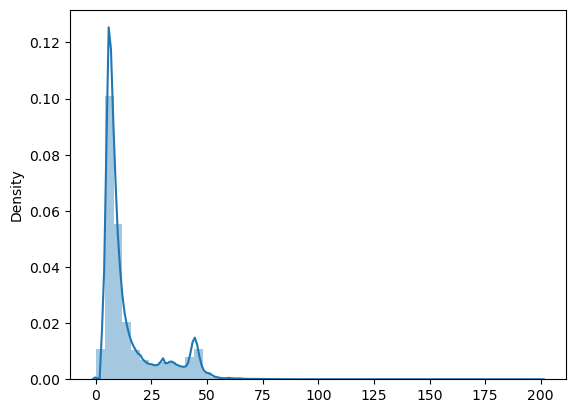

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a single column and sample and convert to pandas
sample_df = taxi_clean.select(['fare']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

After analyzing the fare distribution for each trip, we discovered that the fares have two distinct peaks. The first peak, happens around 10 dollars, possibly represents a cluster of lower-priced fares. While the second peak, around 45 dollars, possibly represents a cluster of higher-priced fares. This finding suggests that there may be two different types of passenger behavior when taking a taxi.

The first peak indicates that people may prefer lower-priced fares because: 

1) They are price-sensitive and want to take a taxi when the fare is low, even for short distances.

2) They may need to pass through dangerous areas, making them more likely to take a taxi rather than other transportations. 

The second peak is more straightforward, indicating that higher fares are likely due to longer distances.

#### Question 2: What is the relation between fares and miles?

In [13]:
# Select a the relevant columns and sample
sample_df = taxi.select(['trip_miles', 'fare']).sample(False, 0.5, 42)
# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

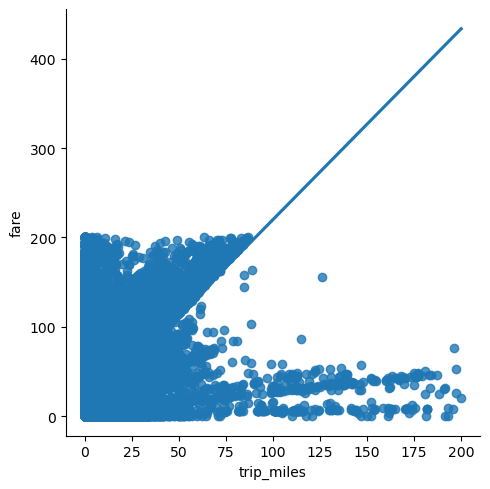

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Linear model plot of pandas_df
sns.lmplot(x='trip_miles', y= 'fare', data=pandas_df)
plt.show()

The correlation between miles and taxi fares is subject to various factors such as location, time of day, and the taxi service provider. Generally, longer distances result in higher fares, as shown in the correlation plot. Although the pricing structure is complex, the plot reveals some interesting patterns:
1. For trips under 60 miles, fares vary widely, ranging from 0 to 200 dollars. This variation may be due to factors such as traffic, tolls.
2. This plot shows two patterns that resemble regression lines for trips longer than 60 miles, located near the bottom of the x axis.  Indicating that different pricing strategies may be at play. Although these trips cover a long distance, most fares are under 100 dollars, suggesting that customers may have discounts or sharing rides with others.

#### Question 3: What are the popular pickup and dropoff locations?

To analyze this question accurately, we added community areas with codes. This is directly taken from an area map of Chicago. 

In [43]:
import pandas as pd

# Load the community code and name
community_area = [("1", "Rogers Park"),("2", "West Ridge"),("3", "Uptown"),("4", "Lincoln Square"),("5", "North Center"),("6", "Lake View"),("7", "Lincoln Park"),("8", "Near North Side"),("9", "Edison Park"),("10", "Norwood Park"),
                  ("11", "Jefferson Park"),("12", "Forest Glen"),("13", "North Park"),("14", "Albany Park"),("15", "Portage Park"),("16", "Irving Park"),("17", "Dunning"),("18", "Montclare"),("19", "Belmont Cragin"),("20", "Hermosa"),
                  ("21", "Avondale"),("22", "Logan Square"),("23", "Humboldt Park"),("24", "West Town"),("25", "Austin"),("26", "West Garfield Park"),("27", "East Garfield Park"),("28", "Near West Side"),("29", "North Lawndale"),("30", "South Lawndale"),
                  ("31", "Lower West Side"),("32", "Loop"),("33", "Near South Side"),("34", "Armour Square"),("35", "Douglas"),("36", "Oakland"),("37", "Fuller Park"),("38", "Grand Boulevard"),("39", "Kenwood"),("40", "Washington Park"),
                  ("41", "Hyde Park"),("42", "Woodlawn"),("43", "South Shore"),("44", "Chatham"),("45", "Avalon Park"),("46", "South Chicago"),("47", "Burnside"),("48", "Calumet Heights"),("49", "Roseland"),("50", "Pullman"),
                  ("51", "South Deering"),("52", "East Side"),("53", "West Pullman"),("54", "Riverdale"),("55", "Hegewisch"),("56", "Garfield Ridge"),("57", "Archer Heights"),("58", "Brighton Park"),("59", "McKinley Park"),("60", "Bridgeport"),
                  ("61", "New City"),("62", "West Elsdon"),("63", "Gage Park"),("64", "Clearing"),("65", "West Lawn"),("66", "Chicago Lawn"),("67", "West Englewood"),("68", "Englewood"),("69", "Greater Grand Crossing"),("70", "Ashburn"),
                  ("71", "Auburn Gresham"),("72", "Beverly"),("73", "Washington Heights"),("74", "Mount Greenwood"),("75", "Morgan Park"),("76", "O'Hare"),("77", "Edgewater")]

community_area_name = pd.DataFrame(community_area, columns=['community_area', 'community_name'])
community_area_name['community_area'] = community_area_name['community_area'].astype('int64')

In [44]:
sample_df_community = taxi.select(['taxi_id','pickup_community_area','dropoff_community_area','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'])\
                                .sample(False, 0.0001, 42)
pandas_df_community = sample_df_community.toPandas()

In [45]:
pickup_community_area = pandas_df_community.groupby('pickup_community_area').count()\
                        .rename(columns={'taxi_id': 'pickup_community_count'})\
                        .reset_index().set_index('pickup_community_area')

dropoff_community_area = pandas_df_community.groupby('dropoff_community_area').count()\
                        .rename(columns={'taxi_id': 'dropoff_community_count'})\
                        .reset_index().set_index('dropoff_community_area')

taxi_community_area = pickup_community_area[['pickup_community_count']] \
                      .merge(dropoff_community_area[['dropoff_community_count']], \
                             left_index=True, right_index=True, how='left')\
                    .where((pickup_community_area['pickup_community_count'] > 50) & \
                           (dropoff_community_area['dropoff_community_count'] > 50))\
                    .reset_index()\
                    .rename(columns={'pickup_community_area': 'community_area'})
taxi_community_area['community_area'] = taxi_community_area['community_area'].astype('int64')

taxi_community_name = taxi_community_area.merge(community_area_name, on='community_area').dropna().set_index('community_name')

taxi_community_name

,community_area,pickup_community_count,dropoff_community_count
community_name,,,
Uptown,3,67.0,84.0
Lake View,6,157.0,219.0
Lincoln Park,7,115.0,191.0
Near North Side,8,1442.0,1414.0
West Town,24,58.0,139.0
Near West Side,28,503.0,508.0
Loop,32,1167.0,978.0
Near South Side,33,130.0,169.0
Garfield Ridge,56,81.0,59.0


Text(0.5, 1.0, 'Common Pickup and Dropoff Communities')

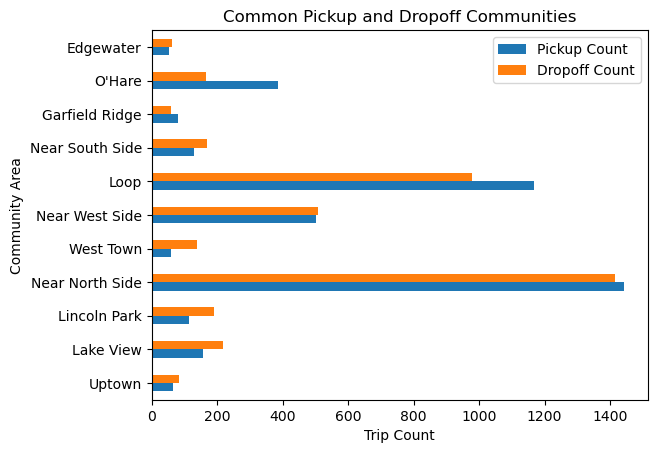

In [46]:
taxi_community_name[['pickup_community_count','dropoff_community_count']].plot.barh()
plt.xlabel('Trip Count')
plt.ylabel('Community Area')
plt.legend(labels=['Pickup Count', 'Dropoff Count'])
plt.title('Common Pickup and Dropoff Communities')

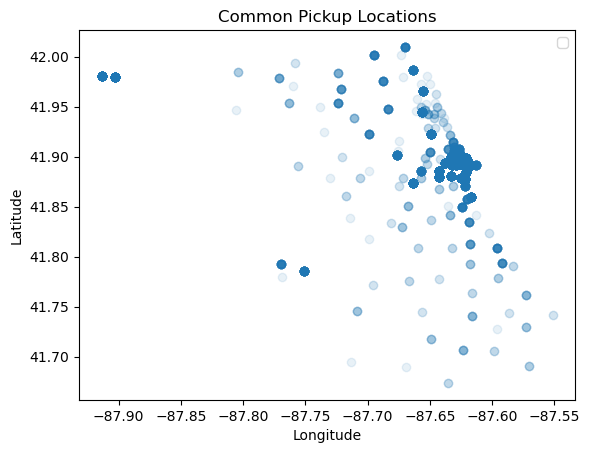

In [48]:
plt.figure()
plt.scatter(pandas_df_community['pickup_longitude'], pandas_df_community['pickup_latitude'], alpha=0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Common Pickup Locations')
plt.legend()

The most popular areas for pick up and drop off tend to correlate, in which a popular pick up area is also a popular drop off area.The more popular areas are Near North Side, Loop, Near West Side and O'Hare.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/Chicago_Community_Areas.svg/690px-Chicago_Community_Areas.svg.png" width="450" align="left"/>
<img src="https://github.com/soltaniehha/Big-Data-Analytics-for-Business/blob/master/figs/07-01-Chicago.png?raw=true" width="450" align="right"/>

#### Question 4: Which Taxi Companies have the highest average tips?

In [4]:
from pyspark.sql.functions import sum, count, avg, expr, desc
# df_tip_mile = taxi.select("trip_miles","tips").sample(withReplacement = False, fraction = 0.005, seed = 42).toPandas().head()
 
dfcomp_tips = taxi.groupBy('company').agg(avg('tips').alias("avg_tips")).orderBy(desc("avg_tips")).toPandas()

dfcomp_tips


,company,avg_tips
0,2809 - 95474 C & D Cab Co Inc.,5.991667
1,4053 - 40193 Adwar H. Nikola,4.905277
2,"2241 - 44667 - Felman Corp, Manuel Alonso",4.360563
3,Petani Cab Corp,4.222615
4,2733 - 74600 Benny Jona,3.709306
...,...,...
76,6743 - 78771 Luhak Corp,0.654435
77,Norshore Cab,0.270183
78,3556 - 36214 RC Andrews Cab,0.108872
79,2092 - 61288 Sbeih company,0.072050


In [5]:
dfcomp_tips = dfcomp_tips.head(5)
dfcomp_tips

,company,avg_tips
0,2809 - 95474 C & D Cab Co Inc.,5.991667
1,4053 - 40193 Adwar H. Nikola,4.905277
2,"2241 - 44667 - Felman Corp, Manuel Alonso",4.360563
3,Petani Cab Corp,4.222615
4,2733 - 74600 Benny Jona,3.709306


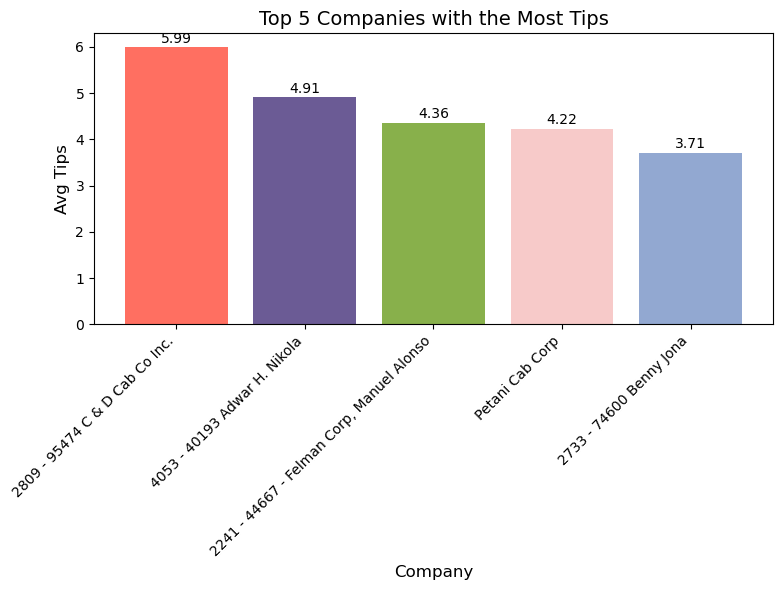

In [8]:
#  color palette
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1']
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(dfcomp_tips['company'], dfcomp_tips['avg_tips'], color=colors)
for i, v in enumerate(dfcomp_tips['avg_tips']):
    ax.text(i, v + 0.1, str(round(v, 2)), ha='center', fontsize=10)
ax.set_xlabel('Company', fontsize=12)
ax.set_ylabel('Avg Tips', fontsize=12)
ax.set_title('Top 5 Companies with the Most Tips', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The top five companies with higher average tips include C & D Cab Co Inc., Adwar H. Nikola, Felman Corp, Manuel Alonso, Petani Cab Corp, and Benny Jona. The highest average tip is 5.99 dollars.

#### Question 5: What is the correlation between Company, Miles and Tips?

In order to determine an accurate correlation, we chose to look into the miles and tips for companies first. Within this group we chose the top 10 companies by average tips per mile. Similar to question 2, we want to keep the miles to a range of Chicago city travel distance.

In [15]:
from pyspark.sql.functions import corr

correlation = taxi.select(corr('trip_miles', 'tips')).first()[0]
print('Correlation between trip miles and tips:', correlation)

Correlation between trip miles and tips: 0.5165643668451496


In [22]:
taxi_miles_tips = taxi.select('company', 'trip_miles', 'tips')

In [23]:
agg_data = taxi_miles_tips.groupBy('company') \
                         .agg(sum('trip_miles').alias('total_miles'), \
                              sum('tips').alias('total_tips'))

In [24]:
avg_data = agg_data.withColumn('avg_tip_per_mile', \
                               agg_data['total_tips'] / agg_data['total_miles'])


In [27]:
avg_data = avg_data.withColumn('avg_tip_per_1000_miles', \
                               avg_data['avg_tip_per_mile'] * 1000)
avg_data = avg_data.sort('avg_tip_per_1000_miles', ascending=False)


In [34]:
avg_data_pd = avg_data.toPandas()

In [35]:
avg_data_pd

,company,total_miles,total_tips,avg_tip_per_mile,avg_tip_per_1000_miles
0,Metro Group,138.6,1270.28,9.165079,9165.079365
1,Blue Ribbon Taxi Association Inc.,650324.3,2865535.16,4.406317,4406.317217
2,Taxi Affiliation Services,21517853.2,14728374.95,0.684472,684.472322
3,1469 - 64126 Omar Jada,15716.8,10200.12,0.648995,648.994706
4,3011 - 66308 JBL Cab Inc.,33163.4,19497.89,0.587934,587.933987
...,...,...,...,...,...
76,5997 - 65283 AW Services Inc.,4803.3,635.25,0.132253,132.252826
77,Norshore Cab,21067.3,2492.71,0.118321,118.321285
78,3556 - 36214 RC Andrews Cab,40125.4,835.05,0.020811,20.811007
79,2092 - 61288 Sbeih company,33026.4,520.78,0.015769,15.768597


In [36]:
avg_data_pd.set_index('company', inplace=True)

In [43]:
 #Filter the relevant rows
tip_miles = taxi.select(['trip_miles', 'tips']).filter(col('trip_miles').cast('float') <= 200)

In [14]:
tip_miles.count()
#dftip_miles = tip_miles.toPandas()

45611238

In [47]:
dftip_miles = tip_miles.limit(1000).toPandas()

In [55]:
taxi_miles_tips = taxi.select('trip_miles', 'tips')
tips_per_1000_miles = taxi_miles_tips.withColumn('tip_per_1000_miles', (col('tips') / col('trip_miles')) * 1000)
tips_per_1000_miles.show()
print(tips_per_1000_miles.count())

+----------+----+------------------+
|trip_miles|tips|tip_per_1000_miles|
+----------+----+------------------+
|       0.5| 0.0|               0.0|
|       0.0| 0.0|              null|
|       0.0| 0.0|              null|
|       1.1| 4.0| 3636.363636363636|
|       0.6| 0.0|               0.0|
|       1.1| 0.0|               0.0|
|       0.0| 2.0|              null|
|      10.8|6.55| 606.4814814814814|
|       0.4| 0.0|               0.0|
|       0.2| 0.0|               0.0|
|       4.8| 4.2| 875.0000000000001|
|       2.1|1.85|  880.952380952381|
|      17.9|10.0| 558.6592178770951|
|       0.0| 0.0|              null|
|       1.0| 0.0|               0.0|
|       0.9| 2.0| 2222.222222222222|
|       2.5| 0.0|               0.0|
|       0.1| 2.2|           22000.0|
|       2.3| 0.0|               0.0|
|      16.8| 9.1| 541.6666666666666|
+----------+----+------------------+
only showing top 20 rows



45611238


In [56]:
# Remove rows with null values in the tip_per_1000_miles column
tips_per_1000_miles_no_nulls = tips_per_1000_miles.filter(col('tip_per_1000_miles').isNotNull())
tips_per_1000_miles_no_nulls.show()
print(tips_per_1000_miles_no_nulls.count())

+----------+----+------------------+
|trip_miles|tips|tip_per_1000_miles|
+----------+----+------------------+
|       0.5| 0.0|               0.0|
|       1.1| 4.0| 3636.363636363636|
|       0.6| 0.0|               0.0|
|       1.1| 0.0|               0.0|
|      10.8|6.55| 606.4814814814814|
|       0.4| 0.0|               0.0|
|       0.2| 0.0|               0.0|
|       4.8| 4.2| 875.0000000000001|
|       2.1|1.85|  880.952380952381|
|      17.9|10.0| 558.6592178770951|
|       1.0| 0.0|               0.0|
|       0.9| 2.0| 2222.222222222222|
|       2.5| 0.0|               0.0|
|       0.1| 2.2|           22000.0|
|       2.3| 0.0|               0.0|
|      16.8| 9.1| 541.6666666666666|
|       8.9| 0.0|               0.0|
|       3.1|2.65| 854.8387096774193|
|       0.4| 0.0|               0.0|
|       0.2| 0.0|               0.0|
+----------+----+------------------+
only showing top 20 rows



39479071


In [57]:
# Remove rows with 0 values in the tip_per_1000_miles column
tips_per_1000_miles_no_zeros = tips_per_1000_miles_no_nulls.filter(col('tip_per_1000_miles') != 0)
tips_per_1000_miles_no_zeros.show()
print(tips_per_1000_miles_no_zeros.count())


+----------+-----+------------------+
|trip_miles| tips|tip_per_1000_miles|
+----------+-----+------------------+
|       1.1|  4.0| 3636.363636363636|
|      10.8| 6.55| 606.4814814814814|
|       4.8|  4.2| 875.0000000000001|
|       2.1| 1.85|  880.952380952381|
|      17.9| 10.0| 558.6592178770951|
|       0.9|  2.0| 2222.222222222222|
|       0.1|  2.2|           22000.0|
|      16.8|  9.1| 541.6666666666666|
|       3.1| 2.65| 854.8387096774193|
|       4.3|  3.0| 697.6744186046512|
|       3.0|  2.2| 733.3333333333334|
|       1.3|  1.0| 769.2307692307692|
|      20.3|13.15| 647.7832512315272|
|       1.0|  2.0|            2000.0|
|       1.0|  9.3|            9300.0|
|       0.2| 4.55|22749.999999999996|
|       1.0|  2.0|            2000.0|
|       8.6| 2.55|296.51162790697674|
|       9.6|  6.8| 708.3333333333334|
|       0.1|  2.0|           20000.0|
+----------+-----+------------------+
only showing top 20 rows



18528264


In [61]:
# Sort the DataFrame by the tip_per_1000_miles column in descending order
sorted_tips_per_1000_miles = tips_per_1000_miles_no_zeros.sort(col('tip_per_1000_miles').desc())
from pyspark.sql.functions import count, sum, avg

# Group by the trip_miles column
grouped_data = sorted_tips_per_1000_miles.groupBy('trip_miles') \
                                         .agg(count('tip_per_1000_miles').alias('count'), \
                                              sum('tip_per_1000_miles').alias('sum_tips_per_1000_miles'), \
                                              avg('tip_per_1000_miles').alias('avg_tips_per_1000_miles'))

# Show the results
grouped_data.show()


+----------+-----+-----------------------+-----------------------+
|trip_miles|count|sum_tips_per_1000_miles|avg_tips_per_1000_miles|
+----------+-----+-----------------------+-----------------------+
|      0.38| 8420|    4.749181578947488E7|     5640.3581697713635|
|      0.66|26094|    8.338633333335641E7|     3195.6132955222047|
|       3.8|45387|   3.5468268421051554E7|      781.4631595181783|
|      13.4|18946|   1.0930505970149346E7|       576.929482220487|
|      14.9|15607|      8724573.154362364|      559.0166690819738|
|      2.86| 7477|      6841597.902098111|      915.0191122239014|
|      3.26| 6164|      5174785.276073661|       839.517403645954|
|      15.5|12976|      7144562.580644829|      550.5982260053044|
|      7.27| 1051|      647246.2173315005|      615.8384560718368|
|      7.02| 1153|       695964.387464388|      603.6117844443955|
|     17.56| 5424|     2876094.5330295996|      530.2534168564896|
|     17.95| 6034|      3213255.710306365|      532.5249768489

In [66]:
print(grouped_data.count())
grouped_data_pd = grouped_data.toPandas()

4691


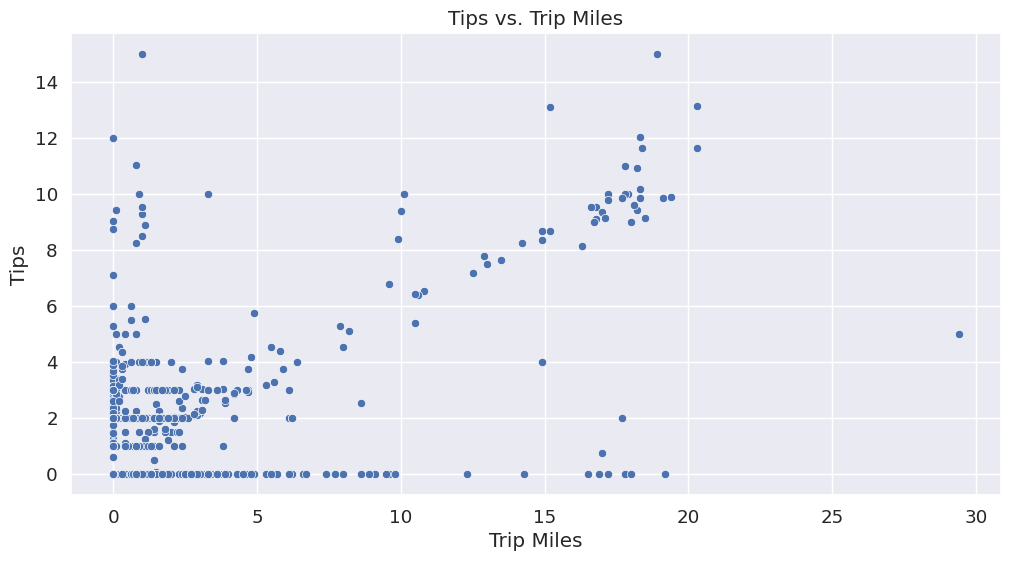

In [92]:
# Convert the Spark DataFrame to a Pandas DataFrame
tip_miles_pd = dftip_miles

# Create the scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=tip_miles_pd, x='trip_miles', y='tips')

# Set plot title and labels
plt.title('Tips vs. Trip Miles')
plt.xlabel('Trip Miles')
plt.ylabel('Tips')

# Show the plot
plt.show()

After transformations and filters, we found that trip miles and tips have a weak positive relation. Although a diagonal trend line can be seen, many other scatter points are not close to this line.

#### Question 6: What are the common payment types? 

In [17]:
spark.conf.set("spark.sql.shuffle.partitions", "100")
dfpayment_type = taxi.groupBy('payment_type').agg(count('taxi_id').alias("Count")).orderBy(desc("Count")).toPandas()

In [19]:
dfpayment_type

,payment_type,Count
0,Cash,21547502
1,Credit Card,20164538
2,Mobile,1528231
3,Prcard,1361477
4,Unknown,921838
5,No Charge,64087
6,Dispute,16782
7,Pcard,3914
8,Prepaid,1472
9,Split,1397


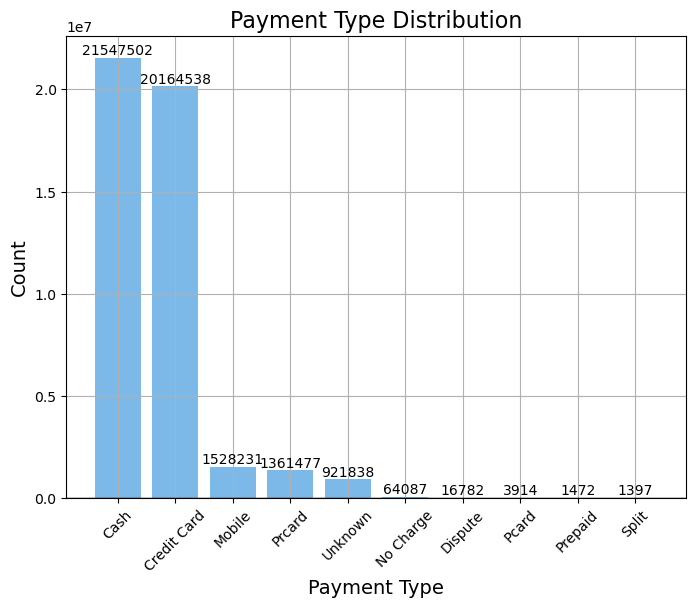

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(dfpayment_type['payment_type'], dfpayment_type['Count'], color='#7CB9E8')

ax.set_xlabel('Payment Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

ax.set_title('Payment Type Distribution', fontsize=16)
ax.grid(True)
ax.axhline(y=0, color='black', linewidth=1)

plt.xticks(rotation=45)

# Add value labels to the bars
for i, count in enumerate(dfpayment_type['Count']):
    ax.annotate(count, (i, count), ha='center', va='bottom')

plt.show()

The most common payment types were cash and credit card by far. Other payment types like mobile suggest app or webplatforms, which can be looked into.

## Conclusion <a id='conclusions'></a>

In this notebook, we used taxi trips for the Chicago dataset and selected data from 2018 to 2022 to explore data. By answering six questions about factors such as fares, trip distance, location, and payment types, we tried to find the traditional taxi business pattern in Chicago now. The questions and answers are the following:

1. At what price point are customers most likely to take a taxi?

We find two distinct peaks: about 10 dollars and about 45 dollars.

2. What is the relation between fares and miles?

In general, longer distances result in higher fares. However, there are still other factors that can affect fares. 

3. What are the popular pickup and dropoff locations?

A popular pickup area is also a popular dropoff area, for example, areas near North Side, Loop, Near West Side, and O'Hare.

4. Which Taxi Companies have the highest average tips?

We ranked the top five companies that have higher average tips, C&D Cab Co Inc. was the highest. The highest average tip is 5.99 dollars for each trip.

5. What is the correlation between Company, Miles, and Tips?

Trip miles and tips have a weak positive relation.

6. What are the common payment types?

The most common payment types were cash and credit card by far.

In the next step, we will look deeper into these patterns and give suggestions about pricing and marketing strategy. In addition, we will reference the Chicago crime dataset to give more location specific recommendations for the dangerous area.

## Reference <a id='references'></a>
1. https://data.cityofchicago.org/
2. https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew
3. https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2
4. https://github.com/soltaniehha/Big-Data-Analytics-for-Business/blob/master/08-EDA-and-Data-Sources/01-EDA.ipynb
5. https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/Chicago_Community_Areas.svg/690px-Chicago_Community_Areas.svg.png
6. https://chat.openai.com/chat, for learning upon running pyspark faster, to lower computation power & learn new concepts of working with big datasets.